In [1]:
from ModellingUtilities import *
from PlotUtilities import *
import os

In [22]:
# trains = pd.read_csv('../PublicGeoJsons/Transport/NS/stations-2022-01-nl.csv').set_index('code')
# SPN = pd.read_csv('../PublicGeoJsons/Transport/NS/StationPassengerNumbers.csv').set_index('CodeUpper')
# trains = trains.join(SPN[['Passengers']])
# trains = gpd.GeoDataFrame(
#     trains, geometry=gpd.points_from_xy(trains.geo_lng, trains.geo_lat), crs="EPSG:4326"
# ).to_crs(28992)[['geometry', 'name_short', 'Passengers']]
# trains.to_pickle('../PublicGeoJsons/Transport/NS/PassengerNumbers_Geo')
trains = pd.read_pickle('../PublicGeoJsons/Transport/NS/PassengerNumbers_Geo').to_crs(28992)
trains.head()

,geometry,name_short,Passengers
code,,,
AC,POINT (127005.741 476800.771),Abcoude,1579.0
AH,POINT (190169.134 444190.916),Arnhem C,39164.0
AHP,POINT (191561.877 444231.913),Velperprt,2066.0
AHPR,POINT (193238.652 444553.469),Presikhaaf,2829.0
AHZ,POINT (186946.620 440831.569),Arnhem Z,2909.0


In [24]:
city = 'AADO'

In [25]:
# def get_metros():
#     trans = gpd.read_file('../PublicGeoJsons/Transport/TransitLines.json').to_crs(28992)
#     trans['lines_list'] = trans['Lijn_select'].str.split('|')
#     metros = trans[trans.Modaliteit == 'Metro']
#     metrolinedict = {'50': 100200/20, '51': 60800/19, '52': 84000/8, '53': 60600/14, '54': 73500/15}
#     metros['metro_passengers'] = metros['lines_list'].apply(lambda x: sum([(metrolinedict[str(line)]) for line in x if line in metrolinedict.keys()]))
#     metros = metros[['Naam', 'geometry', 'metro_passengers']]
#     Trams = trans[trans.Modaliteit == 'Tram']
#     return metros, Trams
# # metros, Trams = get_metros()
# def get_metros2():

In [26]:
# parks  = gpd.read_file('../PublicGeoJsons/Parks/AmsParks.json').to_crs(28992)
# parks.to_pickle('../PublicGeoJsons/Parks/Amsterdam')
# city_parks = parks[parks.Stadspark == 'J']
# rec_green = parks[parks.Stadspark == 'N']
parks = pd.read_pickle('../PublicGeoJsons/Parks/' + city).to_crs(28992)

In [27]:
square_size = 100
grid = pd.read_pickle('../Demand Modelling/Grids/' + city + '/' + str(square_size)).to_crs(28992)

In [28]:
def gridcounts_bool(grid, feature, col_name):
    joined = gpd.sjoin(feature, grid, how='left')
    counts = joined.groupby('index_right').size()
    grid_copy = grid.copy()
    grid_copy['bool_' + col_name] = counts
    grid_copy['bool_' + col_name] = grid_copy['bool_' + col_name].fillna(0)

    return grid_copy
# a = {'park': parks}#,'tram': Trams }
# for key in a.keys():
#     grid = gridcounts_bool(grid, a[key][['geometry']], key)
# grid

In [29]:
def gridcounts_sum(grid, feature, col_name):
    joined = gpd.sjoin(feature, grid, how='left', op='within')
    counts = joined[['index_right', col_name]].groupby('index_right').sum()
    grid['sum_' + col_name] = counts
    grid['sum_' + col_name] = grid['sum_' + col_name].fillna(0)
    return grid

sums = {'Passengers': trains}#{'metro_passengers': metros, 'Passengers': trains}
for key in sums.keys():
    grid = gridcounts_sum(grid, sums[key], key)
grid.head()

/Users/joshuathomas/PycharmProjects/EmbeddedMobility/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,geometry,sum_Passengers
index,,
0,"POLYGON ((110100.000 493800.000, 110200.000 49...",0.0
1,"POLYGON ((110200.000 493800.000, 110300.000 49...",0.0
2,"POLYGON ((110300.000 493800.000, 110400.000 49...",0.0
3,"POLYGON ((110400.000 493800.000, 110500.000 49...",0.0
4,"POLYGON ((110500.000 493800.000, 110600.000 49...",0.0


In [30]:
if city == 'AADO':
    banned = pd.read_pickle('../Service Areas/Ams/Amsterdam --- No parking').to_crs(28992)
if city == 'Rotterdam':
    banned = pd.read_pickle('../Service Areas/Rott/Rotterdam --- No parking Zones').to_crs(28992)
if city == 'Den Haag':
    banned = pd.read_pickle('../Service Areas/Den Haag/Den Haag --- No parking Zones').to_crs(28992)

In [31]:
if city == 'AADO':
    incentive = pd.read_pickle('../Service Areas/Ams/Amsterdam --- Incentive Zones').to_crs(28992)
if city == 'Rotterdam':
    incentive = pd.read_pickle('../Service Areas/Rott/Rotterdam --- Incentive areas').to_crs(28992)
if city == 'Den Haag':
    incentive = pd.read_pickle('../Service Areas/Den Haag/Den Haag --- Incentive areas').to_crs(28992)

In [34]:
if city == 'AADO':
    # water = pd.read_pickle('../PublicGeoJsons/Water/AmsterdamWater').to_crs(28992)
    water = pd.read_pickle('../PublicGeoJsons/Water/' + city)
else:
    water = gpd.read_file('../PublicGeoJsons/Water/' + city)#.to_crs(28992)
water = water.loc[water['geometry'].geom_type.isin(['Polygon', 'MultiPolygon'])].set_crs(28992)

In [35]:
def calc_intersection(city, square_size, area, name, cnngrid):
    banned_all = area
    raw_grid = pd.read_pickle('../Demand Modelling/Grids/' + city + '/' + str(square_size)).to_crs(28992)

    # Calculate intersections
    intersected = gpd.overlay(raw_grid, banned_all, how='intersection')
    intersected['area_intersected' + name] = intersected['geometry'].area
    summed_areas = intersected.groupby('geometry')['area_intersected' + name].sum().reset_index()
    summed_areas = gpd.GeoDataFrame(summed_areas, geometry = 'geometry', crs = 28992)
    # summed_areas.plot(column = 'area_intersected', cmap = 'Reds')
    hi = raw_grid.sjoin(summed_areas, how = 'left').fillna(0).groupby('geometry').nth(0)
    hi['area_intersected' + name] /= raw_grid['geometry'].iloc[0].area
    cnngrid = cnngrid.join(hi[['area_intersected' + name]])
    # if Plot == True:
    # hi.plot(column = 'area_intersected', cmap = 'Reds', legend = True)

    return cnngrid

In [36]:
intersections = {'_no_parking': banned, '_water': water, '_incentive': incentive}
for key in intersections.keys():
    grid = calc_intersection(city, square_size, intersections[key], key, grid)

/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_70787/1588424719.py:6: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersected = gpd.overlay(raw_grid, banned_all, how='intersection')


In [37]:
grid = calc_intersection(city, square_size, parks, '_park', grid)

In [38]:
grid.head()

,geometry,sum_Passengers,area_intersected_no_parking,area_intersected_water,area_intersected_incentive,area_intersected_park
index,,,,,,
0,"POLYGON ((110100.000 493800.000, 110200.000 49...",0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((110200.000 493800.000, 110300.000 49...",0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((110300.000 493800.000, 110400.000 49...",0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((110400.000 493800.000, 110500.000 49...",0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((110500.000 493800.000, 110600.000 49...",0.0,0.0,0.0,0.0,0.0


In [39]:
grid.iloc[:, 1:].sum()

sum_Passengers                 455764.000000
area_intersected_no_parking       470.276209
area_intersected_water          12459.301534
area_intersected_incentive         31.424586
area_intersected_park            2935.042684
dtype: float64

In [40]:
# pc4 = pd.read_pickle('../PostcodeInfo/PC4_Clean')
# pc4 = pc4.rename(columns = {'Unnamed: 36': 'density'})
# pc4['young'] = pc4['15 tot 25 jaar'] + pc4['25 tot 45 jaar']
# pc4 = pc4[['Man', 'density', 'young']]
# density = gpd.read_file('../PublicGeoJsons/NetherlandsPC4.geojson')
# density = density.set_index('PC4')
# density = density.to_crs(28992)[['geometry']]
# infopc4 = density.join(pc4, how = 'inner')
# infopc4.head()
# infopc4.to_pickle('../PostcodeInfo/PC4_Clean_Geo')
# infopc4 = pd.read_pickle('../PostcodeInfo/PC4_Clean_Geo')
# df3 = grid[['geometry']].sjoin(gridinfo, how='inner')
# df3 = df3[~df3.index.duplicated(keep='first')]

In [41]:
gridinfo = pd.read_pickle('../Demand Modelling/Grids/' + city + '/' + str(square_size) + 'info').drop('index_right', axis =1)

In [42]:
cnngrid = grid.join(gridinfo.drop('geometry', axis =1))
filename = os.path.join('../', 'CNN_Demand', 'CNN_Data', city, str(square_size))
cnngrid.to_pickle(filename)
cnngrid.head()

,geometry,sum_Passengers,area_intersected_no_parking,area_intersected_water,area_intersected_incentive,area_intersected_park,aantal_inwoners,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_15_tot_25_jaar
index,,,,,,,,,
0,"POLYGON ((110100.000 493800.000, 110200.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0
1,"POLYGON ((110200.000 493800.000, 110300.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0
2,"POLYGON ((110300.000 493800.000, 110400.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0
3,"POLYGON ((110400.000 493800.000, 110500.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0
4,"POLYGON ((110500.000 493800.000, 110600.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0


In [43]:
# housing = gpd.read_file('../PublicGeoJsons/HousingPrices.json')[['SELECTIE', 'geometry']].to_crs(28992)
# df4 = cnngrid[['geometry']].sjoin(housing, how='inner')
# df4 = df4[~df4.index.duplicated(keep='first')]
# df4 = df4.rename(columns = {'SELECTIE': 'house_price'})
# cnngrid = cnngrid.join(df4.drop(['geometry', 'index_right'], axis =1))
# cnngrid['house_price'].fillna(cnngrid['house_price'].median(), inplace=True)
# # cnngrid.to_pickle(filename)

In [44]:
# cnngrid['sum_all_passengers'] =cnngrid['sum_Passengers'] + cnngrid['sum_metro_passengers']
# cnngrid['young_man_density'] = cnngrid['young'] * cnngrid['Man']* cnngrid['density']

In [45]:
for key, value in {'amenities': 'gdf_amenities', 'Horeca': 'gdf_horeca', 'university': 'gdf_univ', 'tram': 'gdf_tram', 'metro': 'gdf_metro'}.items():
    tt = pd.read_pickle(os.path.join('../', 'OSM', city, str(square_size), key))
    tt =tt.rename(columns = {'name': key})
    cnngrid = cnngrid.join(tt[[key]])

In [46]:
cnngrid

,geometry,sum_Passengers,area_intersected_no_parking,area_intersected_water,area_intersected_incentive,area_intersected_park,aantal_inwoners,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_15_tot_25_jaar,amenities,Horeca,university,tram,metro
index,,,,,,,,,,,,,,
0,"POLYGON ((110100.000 493800.000, 110200.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((110200.000 493800.000, 110300.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0,NaN,NaN,NaN,NaN,NaN
2,"POLYGON ((110300.000 493800.000, 110400.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0,NaN,NaN,NaN,NaN,NaN
3,"POLYGON ((110400.000 493800.000, 110500.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0,NaN,NaN,NaN,NaN,NaN
4,"POLYGON ((110500.000 493800.000, 110600.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54644,"POLYGON ((135500.000 472800.000, 135600.000 47...",0.0,0.0,0.0,0.0,0.0,725.0,115.0,75.0,NaN,NaN,NaN,NaN,NaN
54645,"POLYGON ((135600.000 472800.000, 135700.000 47...",0.0,0.0,0.0,0.0,0.0,725.0,115.0,75.0,NaN,NaN,NaN,NaN,NaN
54646,"POLYGON ((135700.000 472800.000, 135800.000 47...",0.0,0.0,0.0,0.0,0.0,725.0,115.0,75.0,NaN,NaN,NaN,NaN,NaN


In [47]:
cnngrid.to_pickle(os.path.join('../', 'CNN_Demand', 'CNN_Data', city, str(square_size)))

In [48]:
city = 'AADO'
square_size = 100
cnngrid = pd.read_pickle(os.path.join('../', 'CNN_Demand', 'CNN_Data', city, str(square_size)))

In [49]:
felyx = pd.read_pickle('../FelyxData/Raw Movement/Felyx' + city)
felyx2022 = pd.read_pickle('../FelyxData/Raw Movement/Felyx' + city + '2022')
fcomb = pd.concat([felyx, felyx2022]).set_geometry('prev_location').to_crs(28992)
fcomb[['geometry', 'prev_location', 'prev_time', 'time']].to_pickle('../FelyxData/Raw Movement/FelyxCombined' + city )

In [50]:
felyx = pd.read_pickle('../FelyxData/Raw Movement/FelyxCombined' + city).to_crs(28992)
def categorize_time(df, datetime_column, daytime = False): #TODO move to wrangler
    # Convert the datetime column to pandas datetime if it's not already
    df[datetime_column] = pd.to_datetime(df[datetime_column])

    # Create a new column to store the time category
    df['time_category'] = 'Other'

    # Define the time ranges
    morning_start = pd.to_datetime('07:00:00').time()
    morning_end = pd.to_datetime('09:00:00').time()
    daytime_start = pd.to_datetime('09:00:00').time()
    daytime_end = pd.to_datetime('16:00:00').time()
    evening_start = pd.to_datetime('16:00:00').time()
    evening_end = pd.to_datetime('18:00:00').time()

    # Categorize the time for each row
    df.loc[(df[datetime_column].dt.time >= morning_start) & (df[datetime_column].dt.time <= morning_end), 'time_category'] = 'Morning'
    df.loc[(df[datetime_column].dt.time > evening_start) & (df[datetime_column].dt.time < evening_end), 'time_category'] = 'Evening'
    if daytime == True:
        df.loc[(df[datetime_column].dt.time >= daytime_start) & (df[datetime_column].dt.time <= daytime_end), 'time_category'] = 'Daytime'

    return df
felyx = categorize_time(felyx, 'prev_time')
felyx.head()

,geometry,prev_location,prev_time,time,time_category
tripid,,,,,
40272023622111,POINT (4.85416 52.29910),POINT (118225.280 478824.315),2023-06-22 01:09:05+02:00,2023-06-22 01:11:05+02:00,Other
386420234152330,POINT (4.92015 52.38886),POINT (123673.073 488814.202),2023-04-15 23:28:06+02:00,2023-04-15 23:30:06+02:00,Other
82262023526235,POINT (4.86059 52.35918),POINT (119789.182 486069.806),2023-05-26 23:03:05+02:00,2023-05-26 23:05:05+02:00,Other
273820232141614,POINT (4.82859 52.34292),POINT (116470.441 483731.466),2023-02-14 16:12:05+01:00,2023-02-14 16:14:05+01:00,Evening
21402023119186,POINT (4.86780 52.32748),POINT (118887.219 482707.456),2023-01-19 18:04:05+01:00,2023-01-19 18:06:05+01:00,Other


In [51]:
def gridcounts(grid, feature, col_name):
    joined = gpd.sjoin(feature.to_crs(28992), grid.to_crs(28992), how='left', op='within')
    counts = joined.groupby('index_right').size()
    grid['counts_' + col_name] = counts
    grid['counts_' + col_name] = grid['counts_' + col_name].fillna(0)
    return grid

# grid = gridcounts(cnngrid, felyx, 'fstart')
# grid.head()

<Axes: >

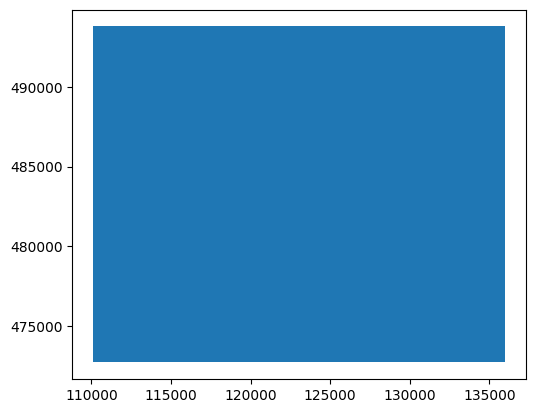

In [52]:
cnngrid.plot()

In [53]:
for time in felyx['time_category'].unique():
    print(time)
    subfelyx = felyx[felyx['time_category'] == time]
    cnngrid = gridcounts(cnngrid, subfelyx, 'fstart_'+ time)

Other


/Users/joshuathomas/PycharmProjects/EmbeddedMobility/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Evening


/Users/joshuathomas/PycharmProjects/EmbeddedMobility/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Morning


/Users/joshuathomas/PycharmProjects/EmbeddedMobility/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [54]:
cnngrid

,geometry,sum_Passengers,area_intersected_no_parking,area_intersected_water,area_intersected_incentive,area_intersected_park,aantal_inwoners,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_15_tot_25_jaar,amenities,Horeca,university,tram,metro,counts_fstart_Other,counts_fstart_Evening,counts_fstart_Morning
index,,,,,,,,,,,,,,,,,
0,"POLYGON ((110100.000 493800.000, 110200.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,"POLYGON ((110200.000 493800.000, 110300.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,"POLYGON ((110300.000 493800.000, 110400.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,"POLYGON ((110400.000 493800.000, 110500.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
4,"POLYGON ((110500.000 493800.000, 110600.000 49...",0.0,0.0,0.0,0.0,0.0,520.0,110.0,60.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54644,"POLYGON ((135500.000 472800.000, 135600.000 47...",0.0,0.0,0.0,0.0,0.0,725.0,115.0,75.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
54645,"POLYGON ((135600.000 472800.000, 135700.000 47...",0.0,0.0,0.0,0.0,0.0,725.0,115.0,75.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
54646,"POLYGON ((135700.000 472800.000, 135800.000 47...",0.0,0.0,0.0,0.0,0.0,725.0,115.0,75.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


<Axes: >

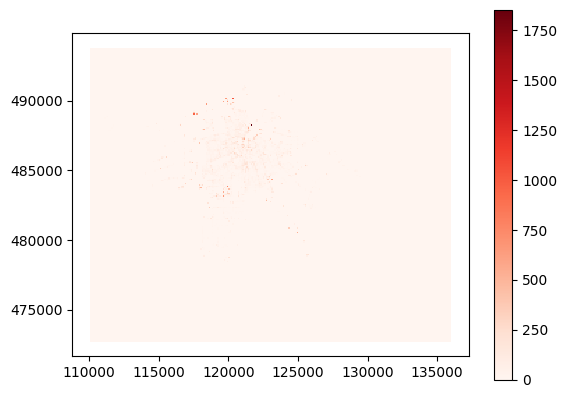

In [55]:
cnngrid.plot(column = 'counts_fstart_Evening', legend = True, cmap = 'Reds')

In [56]:
cnngrid.to_pickle(os.path.join('../', 'CNN_Demand', 'CNN_Data', city, str(square_size)))